## Libraries

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import seaborn as sns
import string

from nltk.corpus import stopwords
from rake_nltk import Rake
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

Setting Options

In [2]:
pd.set_option('display.max_colwidth', 50)
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + list(string.punctuation))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\furka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Json Data Parsing

In [ ]:
raw_df = pd.read_csv("movie_dataset.csv", delimiter=",")

In [ ]:
raw_df.tail()

In [ ]:
def extract_names(json_data):
    encoded_data = json_data.encode('unicode_escape').decode()
    try:
        col = json.loads(json_data)
        names = [x['name'] for x in col]
        return ', '.join(names)
    except Exception as e:
        print(f"Error parsing JSON data '{json_data}': {e}")
        return ""

In [ ]:
genres = raw_df['genres'].apply(extract_names)
keywords = raw_df['keywords'].apply(extract_names)
companies = raw_df['companies'].apply(extract_names)
language = raw_df['language'].apply(extract_names)

raw_df['genres'] = genres
raw_df['keywords'] = keywords
raw_df['companies'] = companies
raw_df['language'] = language

In [ ]:
raw_df

Saving Refined Data

In [ ]:
raw_df.to_excel("rafined_dataset.xlsx", encoding="utf-8")

## Keyword Extraction from Overview

In [ ]:
df = pd.read_excel("rafined_dataset.xlsx")

In [ ]:
df

In [ ]:
r = Rake(stopwords=stop_words, min_length=1, max_length=1, include_repeated_phrases=False)

In [ ]:
def extract_keywords(x):
    r.extract_keywords_from_text(str(x))
    keywords = r.get_ranked_phrases()[:5]
    return ', '.join(keywords)


In [ ]:
overview = df['overview'].apply(extract_keywords)

In [ ]:
overview

In [ ]:
df['overview'] = overview

In [ ]:
df

## Scaling the Categories

In [ ]:
new_df = df

In [ ]:
new_df.describe()

In [ ]:
scaler = MinMaxScaler()

In [ ]:
new_df['year'] = new_df['year'].str[:4]
new_df['year'] = new_df['year'].astype(int)

In [ ]:
df_floats = new_df[['length', 'popularity', 'avarage_rating', 'year', 'adult']]
new_df = new_df.drop(columns = ['length', 'popularity', 'avarage_rating', 'year', 'adult'])
df_floats

In [ ]:
df_floats["adult"] = df_floats["adult"].astype(int)
df_floats["year"] = df_floats["year"].astype(int)

In [ ]:
df_floats['year'] = 2023 - df_floats['year']
df_floats

In [ ]:
df_floats = pd.DataFrame(scaler.fit_transform(df_floats), columns=df_floats.columns[:], index=df_floats.index)
df_floats

In [ ]:
new_df = new_df.iloc[:, 2:]
new_df

In [ ]:
movie_df = df_floats.join(new_df)
movie_df = movie_df.fillna("")

In [ ]:
movie_df

## Vectorizing Bios

In [3]:
movie_df = pd.read_excel("movie_df.xlsx")

In [ ]:
"""
def fix(x):
    words = x.replace(",", "")
    words = words.split()
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

    return ", ".join(filtered_words)
"""

In [ ]:
"""movie_df['keywords'] = movie_df['keywords'].values.astype('U')
movie_df['keywords'] = movie_df['keywords'].apply(fix)"""

In [ ]:
"""def fix2(x):
    words = x.split(", ")
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

    return ", ".join(filtered_words)"""

In [ ]:
"""movie_df['overview'] = movie_df['overview'].values.astype('U')
movie_df['overview'] = movie_df['overview'].apply(fix2)"""

In [ ]:
"""movie_df.to_excel("movie_df.xlsx", encoding="utf-8")"""

In [ ]:
movie_df

In [ ]:
# Instantiating the Vectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "), lowercase=False)

In [ ]:
# Fitting the vectorizer to the Bios
x_genres = vectorizer.fit_transform(movie_df['genres'].values.astype('U'))
df_genres = pd.DataFrame(x_genres.toarray(), columns=vectorizer.get_feature_names_out(), dtype=np.int8)

In [ ]:
x_keywords = vectorizer.fit_transform(movie_df['keywords'].values.astype('U'))
df_keywords = pd.DataFrame(x_keywords.toarray(), columns=vectorizer.get_feature_names_out(), dtype=np.int8)

In [ ]:
x_overview = vectorizer.fit_transform(movie_df['overview'].values.astype('U'))
df_overview = pd.DataFrame(x_overview.toarray(), columns=vectorizer.get_feature_names_out(), dtype=np.int8)

In [ ]:
x_companies = vectorizer.fit_transform(movie_df['companies'].values.astype('U'))
df_companies = pd.DataFrame(x_companies.toarray(), columns=vectorizer.get_feature_names_out(), dtype=np.int8)

In [ ]:
x_language = vectorizer.fit_transform(movie_df['language'].values.astype('U'))
df_language = pd.DataFrame(x_language.toarray(), columns=vectorizer.get_feature_names_out(), dtype=np.int8)

In [ ]:
df_genres

In [ ]:
df_keywords

In [ ]:
df_overview

In [ ]:
df_companies

In [ ]:
df_language

In [ ]:
cols_keywords = [c for c in df_keywords.columns if any(x.isalpha() for x in c)]

df_keywords = df_keywords[cols_keywords]

df_keywords

In [ ]:
cols_overview = [c for c in df_overview.columns if any(x.isalpha() for x in c)]

df_overview = df_overview[cols_overview]

df_overview

In [ ]:
cols_language = [c for c in df_language.columns if any(x.isalpha() for x in c)]

df_language = df_language[cols_language]

df_language

In [ ]:
df_companies.info()

In [ ]:
"""dfs = [df_genres, df_language, df_keywords, df_overview]

# Instantiating PCA
pca = PCA()

for df in dfs:
    # Fitting and Transforming the DF
    df_pca = pca.fit_transform(df)

    # Plotting to determine how many features should the dataset be reduced to
    plt.style.use("bmh")
    plt.figure(figsize=(14,4))
    plt.plot(range(1,df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
    plt.show()

    # Finding the exact number of features that explain at least 95% of the variance in the dataset
    total_explained_variance = pca.explained_variance_ratio_.cumsum()
    n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
    n_to_reach_95 = df.shape[1] - n_over_95

    print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")"""

In [ ]:
# Keywords

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=1164)

# Fitting and transforming the dataset to the stated number of features
df_pca_keywords = pd.DataFrame(pca.fit_transform(df_keywords), columns=pca.get_feature_names_out(), dtype=np.int8)

scaler = MinMaxScaler()

df_pca_keywords = pd.DataFrame(scaler.fit_transform(df_pca_keywords), columns=df_pca_keywords.columns[:], index=df_pca_keywords.index)

In [ ]:
df_pca_keywords.describe()

In [ ]:
# Overview

# Keywords

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=2290)

# Fitting and transforming the dataset to the stated number of features
df_pca_overview = pd.DataFrame(pca.fit_transform(df_overview), columns=pca.get_feature_names_out(), dtype=np.int8)

scaler = MinMaxScaler()

df_pca_overview = pd.DataFrame(scaler.fit_transform(df_pca_overview), columns=df_pca_overview.columns[:], index=df_pca_overview.index)

In [4]:
movies = movie_df[['title']]

movies

,title
0,And Then There Were None
1,Leatherface
2,The Trip to Spain
3,Science Fiction Volume One: The Osiris Child
4,What Happened to Monday
...,...
19110,Gertie the Dinosaur
19111,Her Crowning Glory
19112,"Winsor McCay, the Famous Cartoonist of the N.Y..."
19113,A Corner in Wheat


In [ ]:
movie_df = movie_df.drop(columns = ['title', 'genres', 'keywords', 'overview', 'companies', 'language'])

movie_df

In [ ]:
df_pca_keywords

In [ ]:
matrix_df = pd.concat([movie_df, df_genres, df_language, df_pca_keywords, df_pca_overview], axis=1)

matrix_df = matrix_df.drop(columns=['Column1', 'language_param'])
matrix_df = matrix_df.iloc[: , 1:]

matrix_df

In [ ]:
matrix_df.to_pickle("matrix_df.pkl")

## Performing PCA on the DF

In [5]:
matrix_df = pd.read_pickle("matrix_df.pkl")

In [4]:
matrix_df

,length,popularity,avarage_rating,year,adult,Action,Adventure,Animation,Comedy,Crime,...,pca2280,pca2281,pca2282,pca2283,pca2284,pca2285,pca2286,pca2287,pca2288,pca2289
0,0.191294,0.009568,0.778947,0.517986,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.101947,0.017794,0.547368,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.130584,0.002234,0.684211,0.000000,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.107675,0.024575,0.515789,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.139748,0.110653,0.715789,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19110,0.012600,0.003497,0.652632,0.741007,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19111,0.014891,0.000794,0.610526,0.762590,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19112,0.012600,0.000778,0.589474,0.762590,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19113,0.014891,0.001117,0.631579,0.776978,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Instantiating KMeans
k_means = KMeans(n_clusters=4)

# Fitting
k_means.fit(matrix_df)

# Getting cluster assignments
cluster_assignments = k_means.predict(matrix_df)

# Setting an evaluation score or metric
print(calinski_harabasz_score(matrix_df, cluster_assignments))

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2006.817455531328


In [14]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)
    
    k_means.fit(matrix_df)
    
    cluster_assignments = k_means.predict(matrix_df)
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabasz_score(matrix_df, cluster_assignments))
    
    s_scores.append(silhouette_score(matrix_df, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(matrix_df, cluster_assignments))

C:\Users\furka\AppData\Local\Temp\ipykernel_8836\3358727097.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(cluster_cnt):


  0%|          | 0/18 [00:00<?, ?it/s]

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

In [22]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric
    """
    
    plt.figure(figsize=(40,18))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

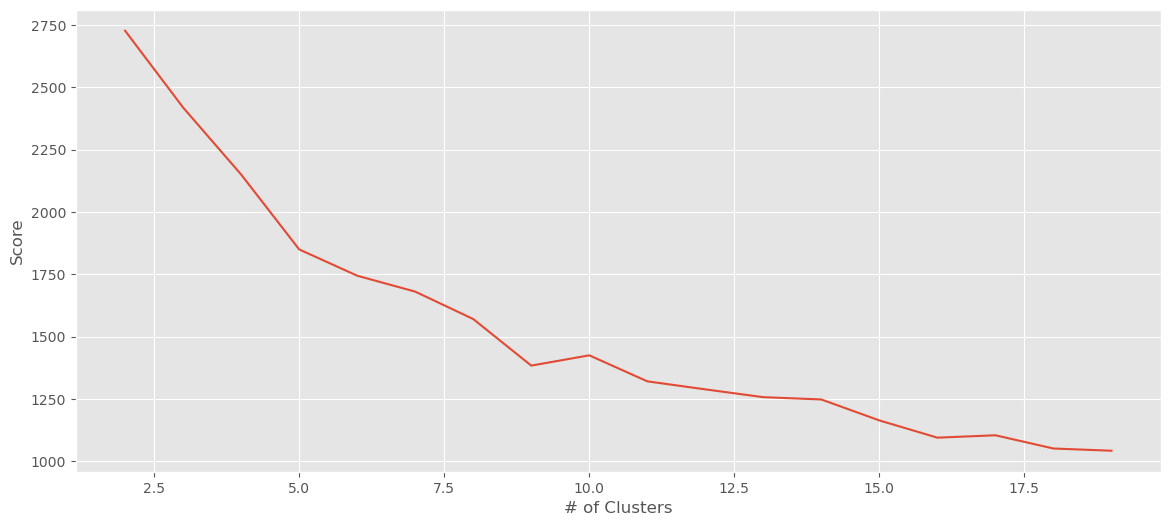

In [16]:
plot_evaluation(ch_scores)

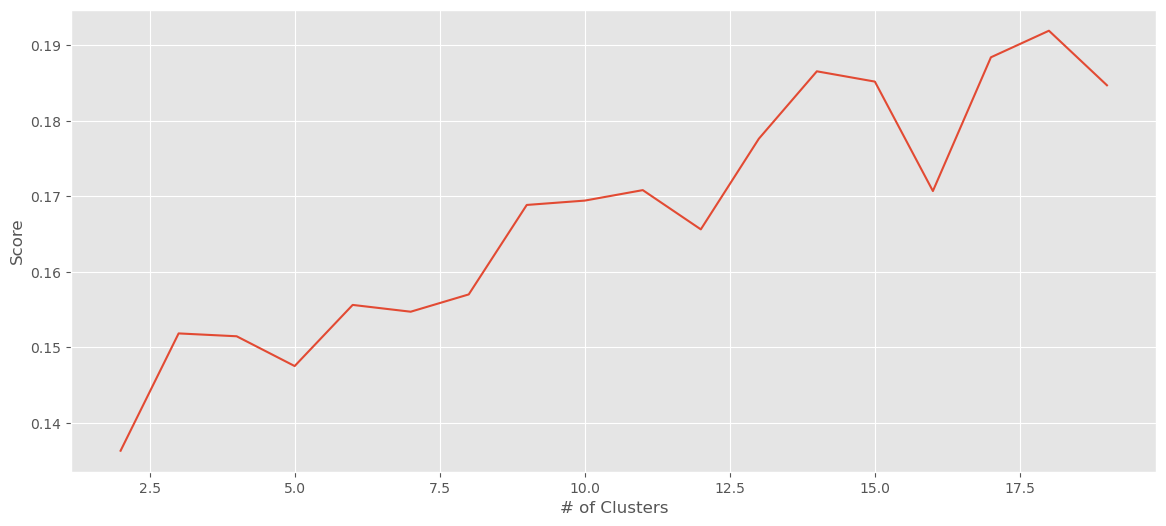

In [17]:
plot_evaluation(s_scores)

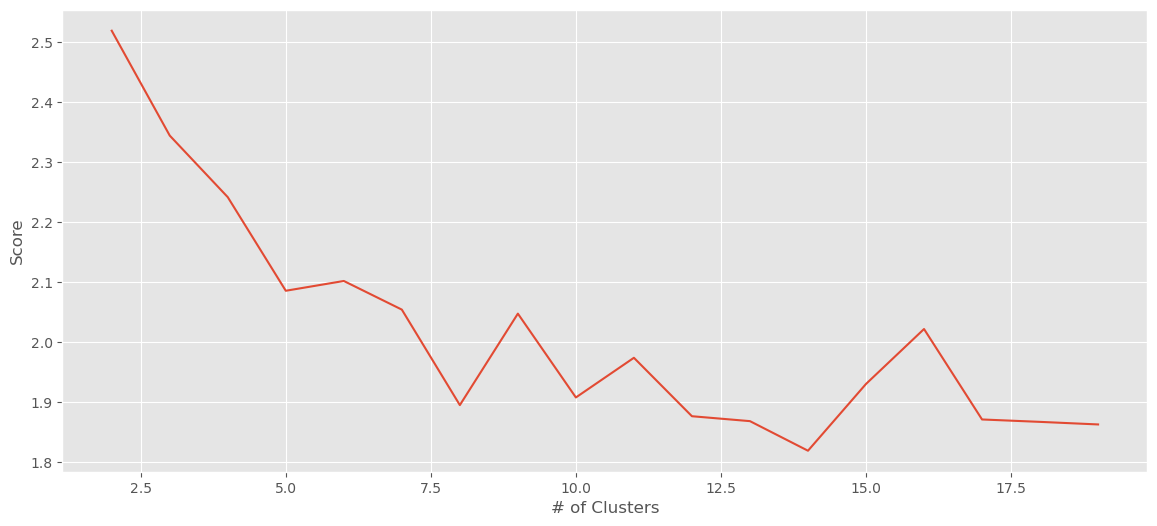

In [18]:
plot_evaluation(db_scores)

In [19]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(20, 60, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)
    
    k_means.fit(matrix_df)
    
    cluster_assignments = k_means.predict(matrix_df)
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabasz_score(matrix_df, cluster_assignments))
    
    s_scores.append(silhouette_score(matrix_df, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(matrix_df, cluster_assignments))

C:\Users\furka\AppData\Local\Temp\ipykernel_8836\4280404307.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(cluster_cnt):


  0%|          | 0/40 [00:00<?, ?it/s]

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


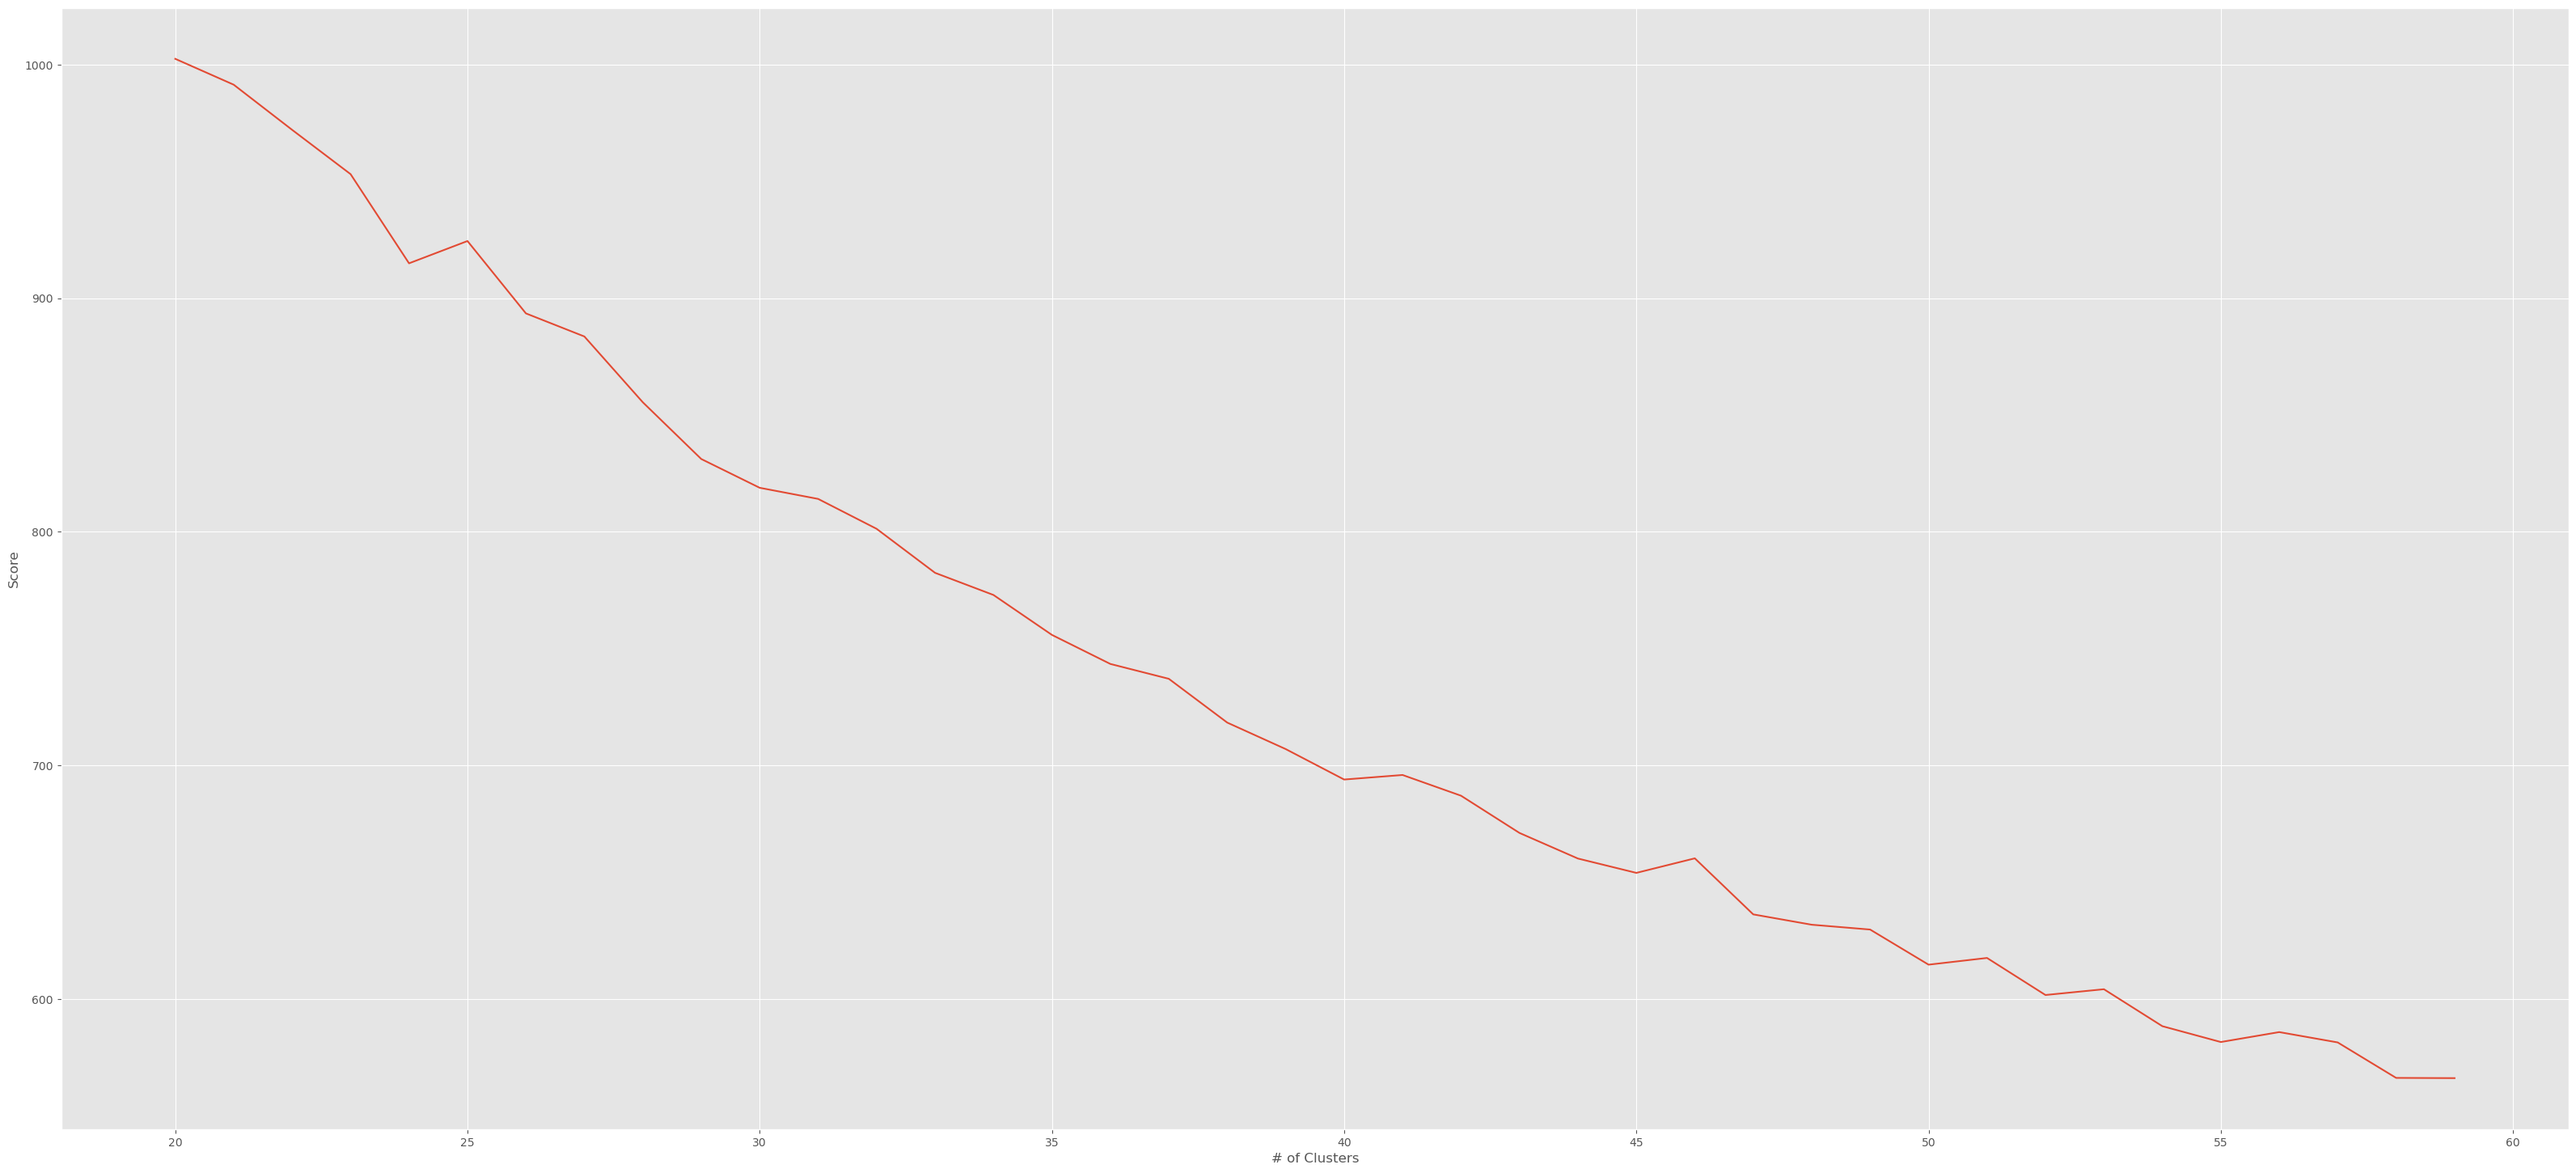

In [23]:
plot_evaluation(ch_scores)

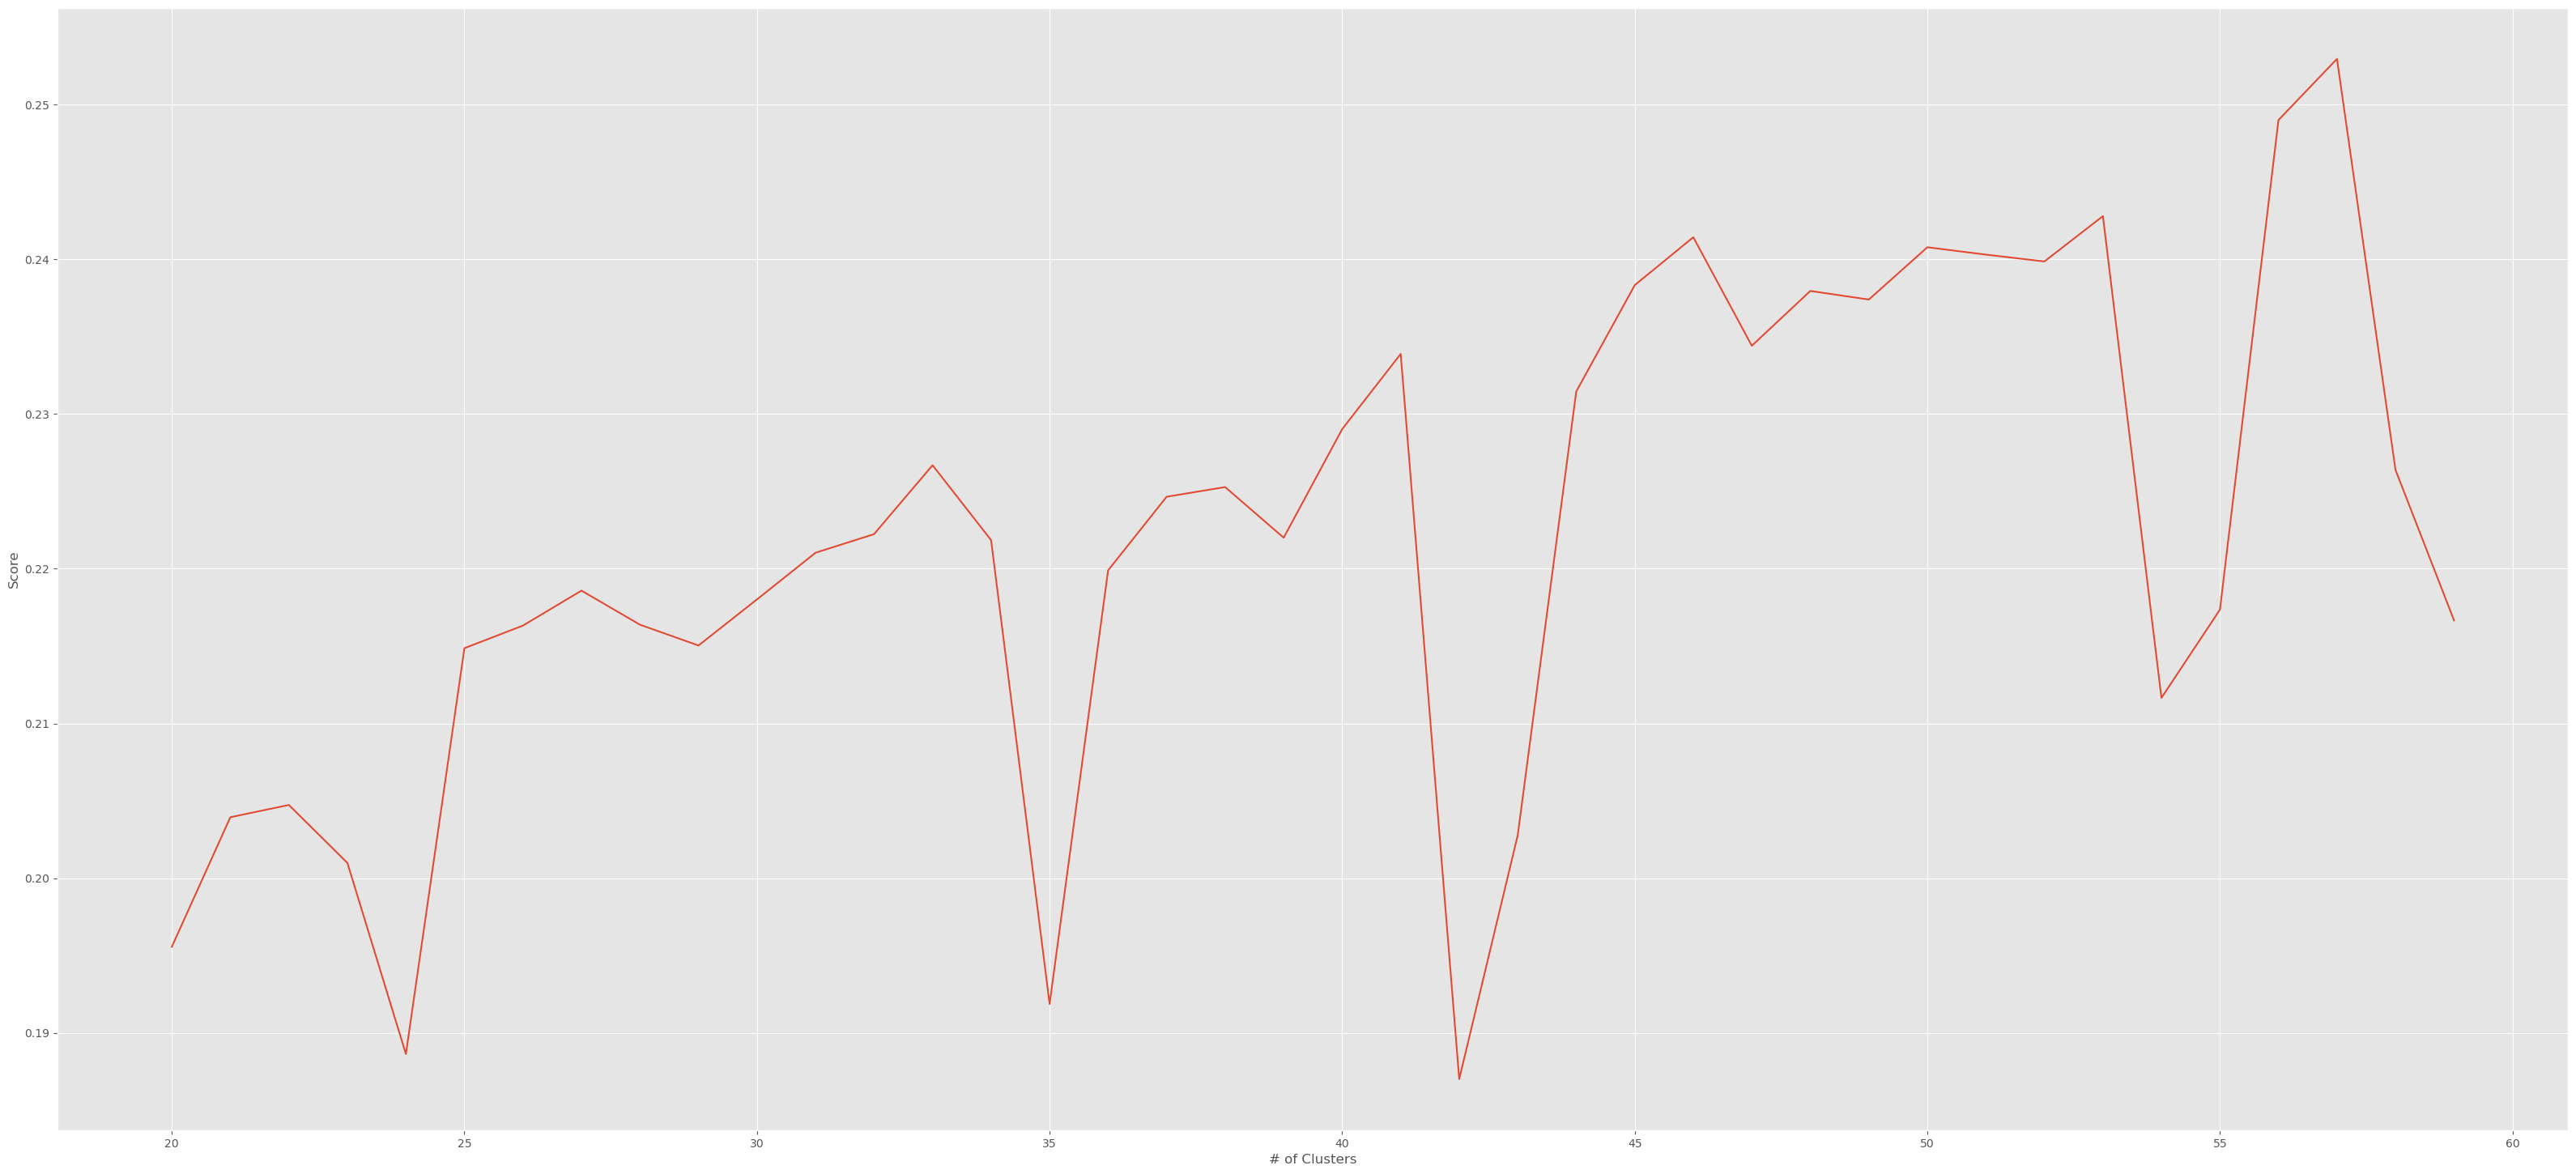

In [24]:
plot_evaluation(s_scores)

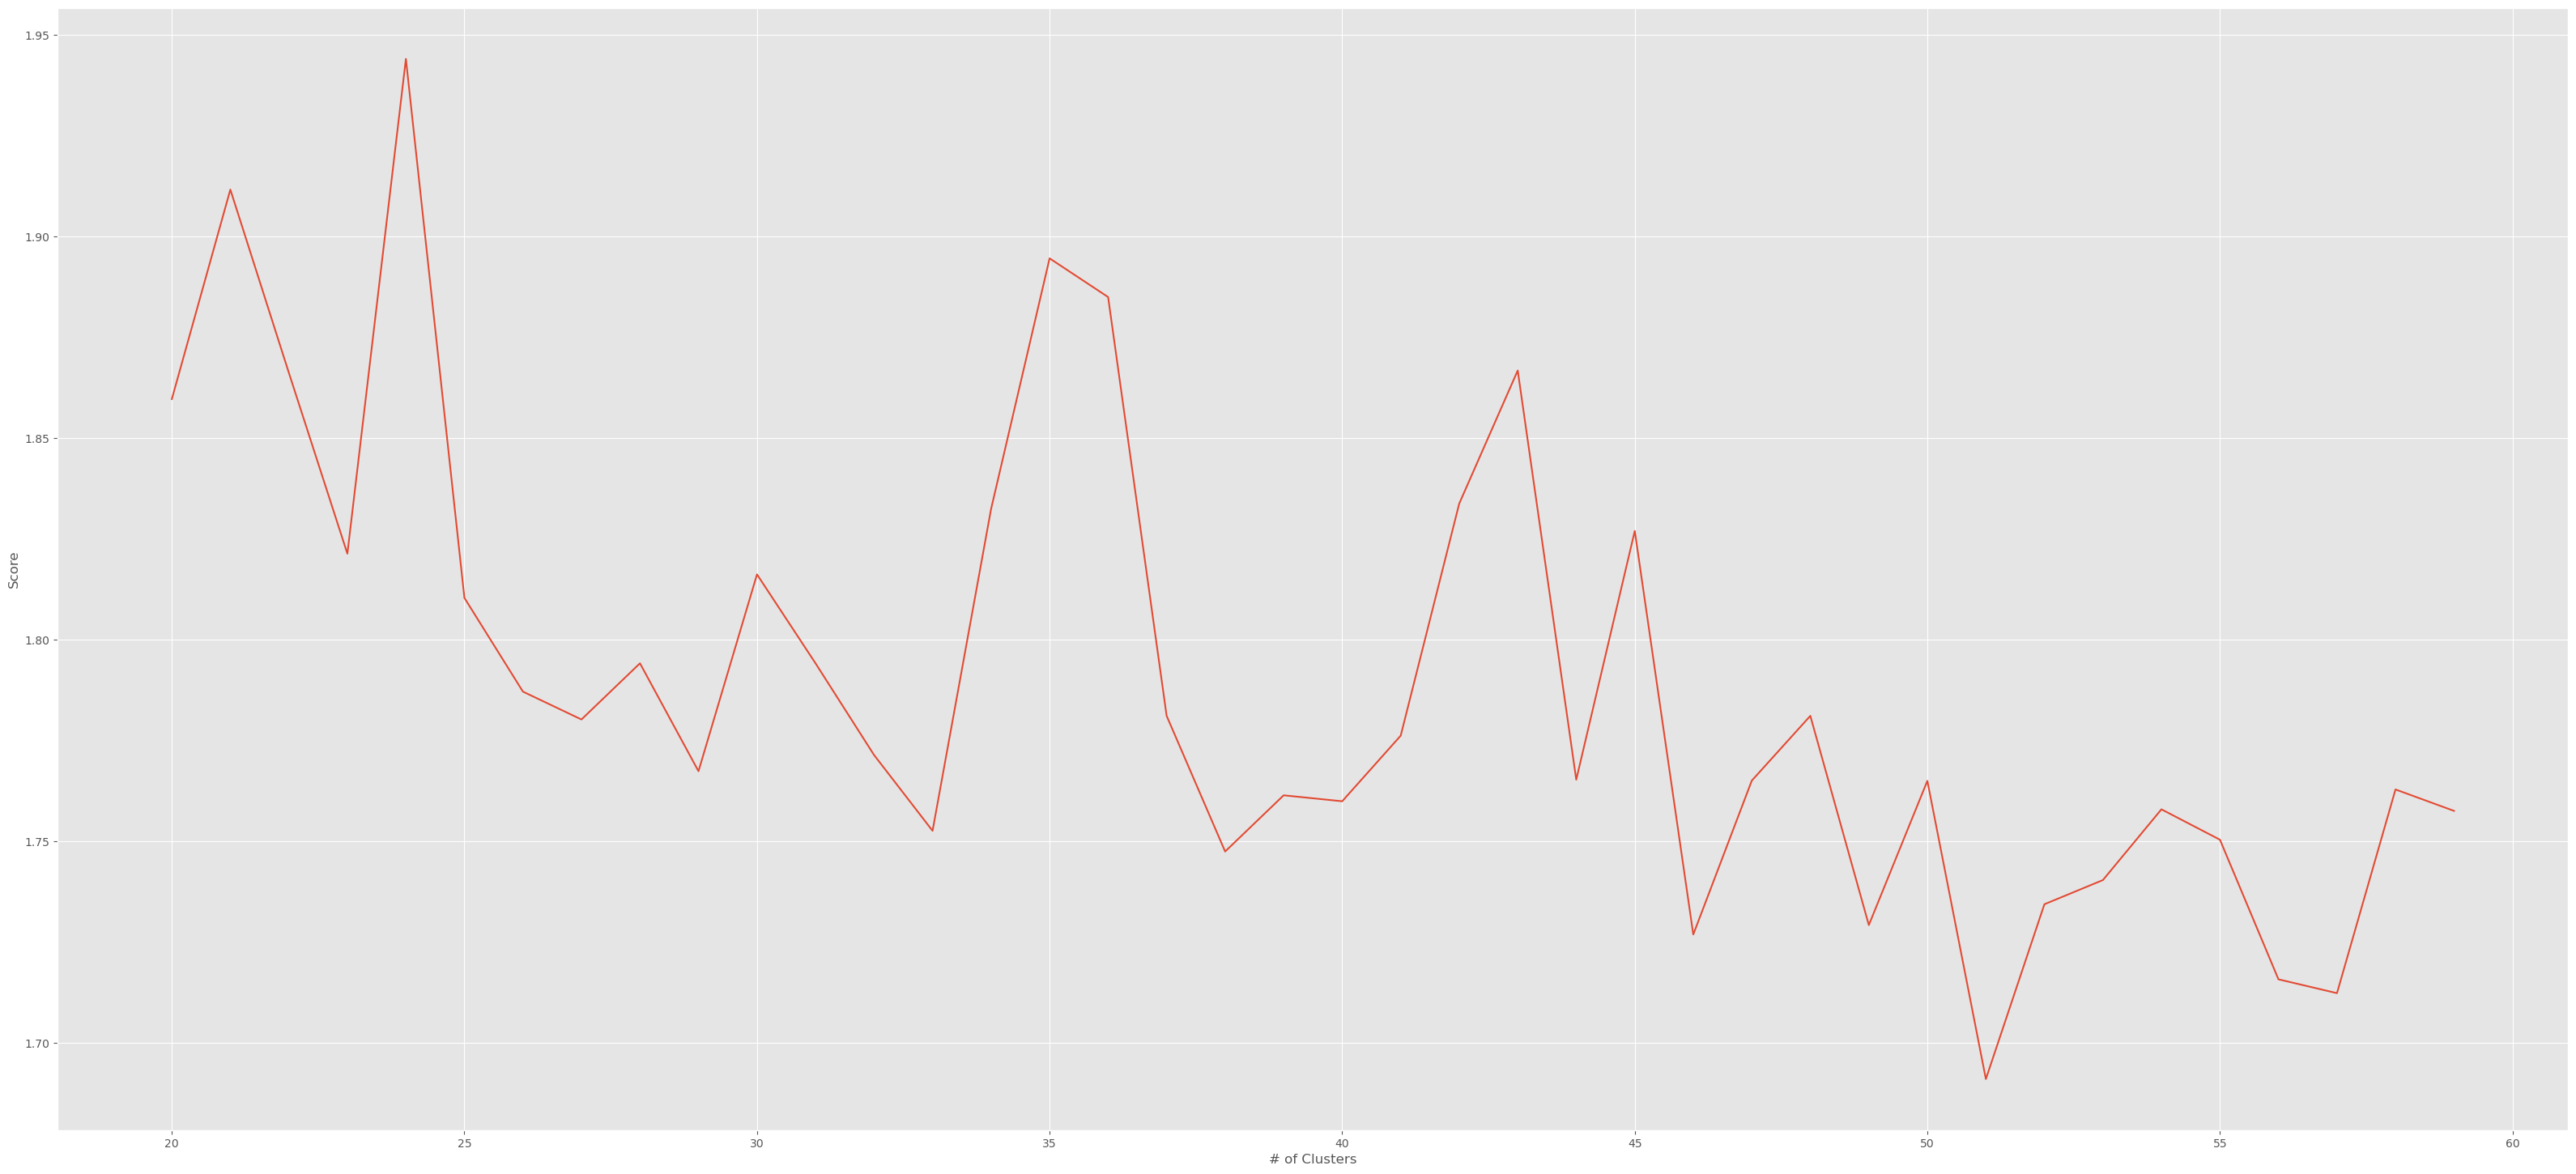

In [25]:
plot_evaluation(db_scores)

In [21]:
print(ch_scores)
print(s_scores) 
print(db_scores)

[1002.5278414320494, 991.4514964522556, 972.1136540272917, 953.1452970368971, 914.9644259072544, 924.5091124464423, 893.5198772398379, 883.6371489809876, 855.4573405597646, 831.1698544481429, 818.8434461633373, 814.0807506316517, 801.2841946132826, 782.4327782012413, 772.9475631613146, 755.8528375730812, 743.41172428761, 737.052386128051, 718.2972565199328, 706.9591969775705, 693.9184769318364, 695.8615697545962, 686.9862592248237, 671.0489723020999, 660.0895480642247, 653.9410504408097, 660.1693447084939, 636.1723955319736, 631.7464543323103, 629.6774577415625, 614.6393061549746, 617.5136073505909, 601.648545651489, 604.1235110238247, 588.2997555192496, 581.5126044574811, 585.7670396361545, 581.3443101663067, 566.1530256979576, 566.0543522475051]
[0.19556436956201081, 0.20393924149315085, 0.20473100173795136, 0.20098461863217632, 0.1886315663289091, 0.21486669155306512, 0.21632630202128955, 0.21858751927769549, 0.2163843133563147, 0.21503973230891682, 0.21802085085610723, 0.2210357514

## KMeans - Best Score - 33

In [50]:
random_movie = random.randint(0, 19115)

movies.loc[random_movie]

title    Leatherface
Name: 1, dtype: object

In [6]:
# Instantiating HAC
kmeans = KMeans(n_clusters=33)

# Fitting
kmeans.fit(matrix_df)

# Getting cluster assignments
cluster_assignments = kmeans.labels_

# Assigning the clusters to each profile
matrix_df['Cluster #'] = cluster_assignments

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
profile_df

,length,popularity,avarage_rating,year,adult,Action,Adventure,Animation,Comedy,Crime,...,pca2280,pca2281,pca2282,pca2283,pca2284,pca2285,pca2286,pca2287,pca2288,pca2289
1,0.101947,0.017794,0.547368,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.111111,0.004675,0.726316,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.104238,0.001612,0.589474,0.000000,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.132875,0.000866,0.663158,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,0.101947,0.018208,0.621053,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18887,0.068729,0.004607,0.578947,0.611511,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18936,0.005727,0.000275,0.578947,0.618705,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18951,0.081329,0.013705,0.705263,0.618705,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19055,0.097365,0.001962,0.578947,0.654676,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Trasnposing the DF so that we are correlating with the index(users) and finding the correlation


In [54]:
matrix_df.loc[top_10_sim.index]

,length,popularity,avarage_rating,year,adult,Action,Adventure,Animation,Comedy,Crime,...,pca2281,pca2282,pca2283,pca2284,pca2285,pca2286,pca2287,pca2288,pca2289,Cluster #
183,0.111111,0.001341,0.547368,0.000000,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1426,0.095074,0.014795,0.536842,0.014388,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1677,0.104238,0.008314,0.536842,0.014388,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
767,0.098511,0.008036,0.526316,0.007194,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1342,0.112257,0.012509,0.526316,0.014388,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1278,0.109966,0.032152,0.526316,0.014388,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2273,0.099656,0.009008,0.526316,0.021583,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2085,0.111111,0.019958,0.568421,0.021583,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2283,0.101947,0.005327,0.526316,0.021583,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
324,0.092784,0.005059,0.515789,0.007194,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [55]:
movies.loc[top_10_sim.index]

,title
183,The Raking
1426,We Are Still Here
1677,The Atticus Institute
767,The ReZort
1342,A Christmas Horror Story
1278,Sinister 2
2273,Let Us Prey
2085,Starry Eyes
2283,From the Dark
324,Siren


In [8]:
def find_top_10_similar_movies(movie_id):
    
    # Getting the Cluster # for the new profile
    profile_cluster = matrix_df.loc[movie_id]['Cluster #']

    # Using the Cluster # to narrow down the DF
    profile_df = matrix_df[matrix_df['Cluster #']==profile_cluster].drop('Cluster #', axis=1)
    
    corr = profile_df.T.corr()

    # Creating a DF with the Top 10 most similar profiles
    top_10_sim = corr[[movie_id]].sort_values(by=[movie_id],axis=0, ascending=False)[1:11]
    
    print(f"Movie: {movies.loc[movie_id][0]}\n")
    print("---------------------")
    print("Top 10 Similar Movies")
    print("---------------------\n")
    print(movies.loc[top_10_sim.index])

In [69]:
find_top_10_similar_movies(2083)

Movie: Guardians of the Galaxy

---------------------
Top 10 Similar Movies
---------------------

                                              title
8584                                          X-Men
2905                        Star Trek Into Darkness
8015   Star Wars: Episode II - Attack of the Clones
10526                            The Fantastic Four
2325            Captain America: The Winter Soldier
5006                                      Star Trek
1352                                        Ant-Man
10762                      Babylon 5: The Gathering
2807                                    Pacific Rim
6981   Star Wars: Episode III - Revenge of the Sith


In [70]:
find_top_10_similar_movies(8015)

Movie: Star Wars: Episode II - Attack of the Clones

---------------------
Top 10 Similar Movies
---------------------

                                              title
10762                      Babylon 5: The Gathering
2905                        Star Trek Into Darkness
12565                          The Last Starfighter
8922      Star Wars: Episode I - The Phantom Menace
9528                  The Lost World: Jurassic Park
9828                               Independence Day
4199                                   TRON: Legacy
3959                 Transformers: Dark of the Moon
6981   Star Wars: Episode III - Revenge of the Sith
8071                               The Time Machine


In [72]:
find_top_10_similar_movies(7526)

Movie: The Matrix Revolutions

---------------------
Top 10 Similar Movies
---------------------

                            title
7686          The Matrix Reloaded
4905  G.I. Joe: The Rise of Cobra
4117             I Am Number Four
3971                Green Lantern
7824           Star Trek: Nemesis
6932                   The Island
9048      Star Trek: Insurrection
4800                   Surrogates
3388                 Total Recall
7719                     The Core


In [14]:
find_top_10_similar_movies(6775)

Movie: Harry Potter and the Goblet of Fire

---------------------
Top 10 Similar Movies
---------------------

                                              title
9989                                        Jumanji
3679                                      Neverland
7850        Harry Potter and the Chamber of Secrets
7341       Harry Potter and the Prisoner of Azkaban
4931         Harry Potter and the Half-Blood Prince
4256   Harry Potter and the Deathly Hallows: Part 1
3947   Harry Potter and the Deathly Hallows: Part 2
7497                                      Peter Pan
9937                             Gulliver's Travels
12196                                     Labyrinth
